In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [2]:
class LightFilter(object):
    def __init__(self, size, data_path, image_path, brightness_limit1, brightness_limit2):
        self.size = size
        self.data_path = data_path
        self.image_path = image_path
        self.brightness_limit1 = brightness_limit1
        self.brightness_limit2 = brightness_limit2


    
    def mask_preparation(self):
        """ creates a distribution mask from a file, normalizing the original values """
        data = pd.read_csv(self.data_path, sep=" ", header=None)
        minimal_el = data.min(axis = 1).min()
        max_el = data.max(axis = 1).max()
        data = (data - minimal_el)/(max_el - minimal_el)
        mask = data.to_numpy()
        mask = np.array(Image.fromarray(mask).resize(self.size, Image.BILINEAR))
        mask = mask[:,:,np.newaxis]
        return(mask)

    
    def bright_image(self):
        """ creates a fully illuminated image using augmentation RandomBrightnessContrast  """
        img = Image.open(self.image_path)
        out = img.resize(self.size)
        img_np = np.array(out)
        image = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        transform = A.Compose([ A.RandomBrightnessContrast(always_apply= True, p=1.0, brightness_limit=(self.brightness_limit1, self.brightness_limit2), contrast_limit=(1.0, 1.0))])
        transformed = transform(image=image)
        src_light = transformed['image']
        src_light_  = cv2.cvtColor(src_light, cv2.COLOR_RGB2BGR)
        return(src_light_)



    def final_image(self,  mask, src_light, src1):
        """ applies a mask according to the formula below, saves the final image """
        dst = src_light * mask + src1 * (1 - mask)
        Image.fromarray(dst.astype(np.uint8)).save('final.jpg')
        image = Image.open('final.jpg')
        return(image)

  
    def initial_picture(self):
        """ brings the original image to the desired size and returns it as np.array """
        img = Image.open(self.image_path)
        out = img.resize(self.size)
        img_np = np.array(out)
        return(img_np)


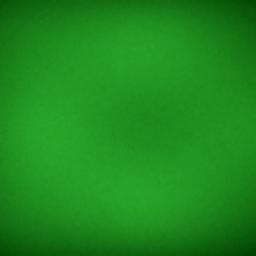

In [3]:
ex = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 )
ex.final_image(ex.mask_preparation(), ex.bright_image(), ex.initial_picture())